# IMDb Top 250 Movies Analysis

## Import required libraries

In [108]:
import requests
from bs4 import BeautifulSoup  
import re
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt

## Open csv file

In [109]:
csv_file = open('imdbtop250.csv', 'w', encoding='UTF8')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['rank', 'title', 'year', 'director', 'duration(minutes)', 'genre', 'rating', 'oscars', 'awards', 'nominations'])

83

## Get URL

In [110]:
url = 'https://www.imdb.com/chart/top'
response = requests.get(url)
response.raise_for_status() #error   

In [111]:
soup = BeautifulSoup(response.text, "html.parser")

## Function to get info from individual movie links

In [112]:
def more_info(url):
    detail = requests.get(url)
    soup = BeautifulSoup(detail.text, "html.parser")
    style = soup.find('div', class_='sc-910a7330-4 kcpPzf')
    if style:
        gd = style
    else:
        gd = soup.find('div', class_='sc-fa02f843-0 fjLeDR')
    
    genres = []
    oscars = []
    
    # Genre
    for genre in gd.find_all('span', class_='ipc-chip__text'): genres.append(genre.text)
    
    # Director 
    director = gd.find('li', class_='ipc-inline-list__item').text
    
    # Runtime in minutes
    runtime = soup.find('div', class_='sc-94726ce4-3 eSKKHi').ul.find_all('li', class_='ipc-inline-list__item')[2].text
    time = re.findall('\d+', runtime)
    if len(time) > 1: minutes = int(time[0])*60 + int(time[1]) 
    else: minutes = int(time[0]*60)
    
    award = soup.find('div', class_='sc-fcdc3619-0 YgLMu base').ul.text
    num = re.findall('\d+', award)
    if award.split(' ')[0] == 'Won': oscars.append(int(num[0][0]))
    elif award.split(' ')[0] == 'Nominated': oscars.append(0)
    else: oscars.append(0) # if there are no nominations 
        
    return genres, director, minutes, oscars[0], num[len(num)-2], num[len(num)-1]

## Main page scraping

In [113]:
movies = soup.find('tbody', class_='lister-list').find_all('tr')
for movie in movies:
    rank = movie.find('td', class_='titleColumn').get_text(strip=True).split('.')[0]
    name = movie.find('td', class_='titleColumn').a.text
    year = movie.find('td', class_='titleColumn').span.text.replace('(','').replace(')','')
    rating = movie.find('td', class_='ratingColumn imdbRating').strong.text
    
    base = 'https://www.imdb.com/'
    href = movie.find('td', class_='titleColumn').a.get('href')
    url = base+href  
    
    genres, director, minutes, oscars, awards, nominations = more_info(url)
    
    csv_writer.writerow([rank, name, year, director, minutes, genres, rating, oscars, awards, nominations])

## Close csv file

In [114]:
csv_file.close()

## Load data

In [115]:
df = pd.read_csv('imdbtop250.csv', index_col='rank')
df.head()

,title,year,director,duration(minutes),genre,rating,oscars,awards,nominations
rank,,,,,,,,,
1,The Shawshank Redemption,1994,Frank Darabont,142,['Drama'],9.2,0,21,43
2,The Godfather,1972,Francis Ford Coppola,175,"['Crime', 'Drama']",9.2,3,31,30
3,The Dark Knight,2008,Christopher Nolan,152,"['Action', 'Crime', 'Drama']",9.0,2,159,163
4,The Godfather Part II,1974,Francis Ford Coppola,202,"['Crime', 'Drama']",9.0,6,17,20
5,12 Angry Men,1957,Sidney Lumet,96,"['Crime', 'Drama']",8.9,0,17,13


In [84]:
year_ratings = df.groupby('year').rating.mean()
year_ratings

year
1921    8.200000
1924    8.100000
1925    8.100000
1926    8.100000
1927    8.200000
          ...   
2018    8.300000
2019    8.233333
2020    8.200000
2021    8.100000
2022    8.300000
Name: rating, Length: 86, dtype: float64

<AxesSubplot:xlabel='year', ylabel='rating'>

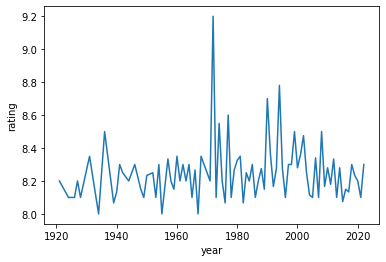

In [85]:
sns.lineplot(data=year_ratings)

In [86]:
#filters
before = df['year'] < 2000 
after = df['year'] > 2000

In [87]:
df.loc[before].count()

title     153
year      153
rating    153
dtype: int64

In [88]:
df.loc[after].count()

title     92
year      92
rating    92
dtype: int64

([<matplotlib.patches.Wedge at 0x24f6bea1910>,
 [Text(-0.4193222704600219, 1.0169409193735162, 'Before 2000'),
  Text(0.4193222704600221, -1.0169409193735162, 'After 2000')],
 [Text(-0.2287212384327392, 0.5546950469310088, '62%'),
  Text(0.22872123843273928, -0.5546950469310088, '38%')])

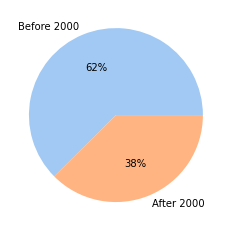

In [89]:
percent = [df.loc[before].title.count(), df.loc[after].title.count()]
labels = ['Before 2000', 'After 2000']
colors = sns.color_palette('pastel')[0:2]
plt.pie(percent, colors=colors, labels=labels, autopct='%.0f%%')
